## Equilibrium Monte Carlo simulation of the 2D Ising model

https://nbviewer.org/urls/www.numfys.net/media/notebooks/ex_qm1_numerical_determination_of_eigenvalues_for_harmonic_oscillator.ipynb

In [1]:
# Imporing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.optimize
import scipy.special
%matplotlib inline

newparams = {'figure.figsize': (15, 7), 'axes.grid': False,
             'lines.markersize': 10, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral', 'figure.dpi': 200}
plt.rcParams.update(newparams)

In [2]:
def Hamiltonian(S, B= 0, J_v= 1, J_p=1):
    """Given a lattice configuration (i.e. a spin matrix) S, and the parameters B, J_v and J_p, this functions
     returns the energy of the lattice.
        
        Parameters:
            S: Spin matrix, (NxN) array
            B, J_v, J_p: Interactation and external parameters
        Returns:
            E: Energy of the lattice
    """
    B_contribution = B * np.sum(S) # Energy of the spin configuration resulting from an external magnetic field
    
    # Using np.roll here automatically satisifies the periodic boundary conditions (PBCs).
    J_v_contribution = J_v * np.sum(S * np.roll(S, 1, axis= 0)) # Energy resulting from lattice interactions along columns
    J_p_contribution = J_p * np.sum(S * np.roll(S, 1, axis= 1)) # Energy resulting from lattice interactions along rows
    E = - (J_v_contribution + J_p_contribution + B_contribution)
    return E


def delta_Hamiltonian(S, i, k, N, B = 0, J_v = 1, J_p = 1):
    """Calculates the energy change of the lattice if lattice site S[i][k] changes it's spin, in accordance
    to the simplifications in the theory part.
        
        Parameters:
            S: Spin matrix, (NxN) array
            i, k: indicates the lattice site
            N: Number of columns and rows in the lattice
            B, J_v, J_p: Interactation and external parameters
        Returns:
            delta_E: The energy change
        """
    # Here we use the modulo operator to accomodate the PBCs 
    nn = J_p * (S[(i + 1) % N][k] + S[i - 1][k]) + J_v * (S[i][(k + 1) % N] + S[i][k - 1])
    delta_E = 2 * S[i][k] * (nn + B)
    return delta_E


def Attempt_flip(S, beta, i, k, N, r, B = 0, J_v = 1, J_p = 1):
    """The central part of the Metropolis algorithm. Calculates the energy change at a random lattice site, and
    updates the spin of the lattice site in accordance to the rules of the Metropolis algorithm. Returns
    True/False on whether the spin should flip as well as the change in energy.
    
        Parameters:
            S: Spin matrix, (NxN) array
            beta: Inverse temperature
            i, k: indicates the lattice site
            N: Number of columns and rows in the lattice
            r: Random number between 0 and 1
            B, J_v, J_p: Interactation and external parameters
        Returns:
            delta_E: The energy change
            flip : Boolean value on wheter the spin should be flipped.
        """
    delta_E = delta_Hamiltonian(S, i, k, N, B, J_v, J_p)
    if delta_E <= 0:
        flip = True # If the energy change is negative, the spin flips
        return flip, delta_E
    else:
        flip = np.exp(-beta * delta_E) > r # The flip might flip, depending on r and the temperature
        return flip, delta_E



def sweep(S, beta, N, B = 0, J_v = 1, J_p = 1):
    """A full Monte Carlo sweep. Runs the previous functions N ** 2 times, while always storing the updated change in
    magnetization and energy. Returns the updated spin configuaration and the change in magnetization and
    energy (with respect to the initial values).
    
        Parameters:
            S: Spin matrix, (NxN) array
            beta: Inverse temperature
            N: Number of columns and rows in the lattice
            B, J_v, J_p: Interactation and external parameters
        Returns:
            S: Updated spin configuartion after one Monte Carlo sweep
            delta_He_sweep: Change in energy after one Monte Carlo sweep
            delta_m_sweep: Change in magnetization after one Monte Carlo sweep
        """
    delta_m_sweep = 0
    delta_He_sweep = 0
    # Generating random numbers to genereate random lattice sites 
    rand_list_index_1 = np.random.randint(N, size=N ** 2)
    rand_list_index_2 = np.random.randint(N, size=N ** 2)
    # Generating N ** 2 random numbers between 0 and 1
    rand_numbers = np.random.rand(N**2)
    for l in range(N ** 2):
        i = rand_list_index_1[l]
        k = rand_list_index_2[l]
        check, delta_E = Attempt_flip(S, beta, i, k, N, rand_numbers[l], B, J_v, J_p)
        if check:
            delta_m = (-2) * S[i][k] / (N ** 2)
            S[i][k] *= (-1)
        else:
            delta_m = 0
            delta_E = 0
        delta_He_sweep += delta_E
        delta_m_sweep += delta_m
    return S, delta_He_sweep, delta_m_sweep



def compute_quantities(S, beta, M, B = 0, J_v = 1, J_p = 1, show_time= False):
    """Given the number of wanted sweeps, M, the simulation is ran for M Monte Carlo sweeps. Returns arrays with
    the values of magnetization and energy after each sweep.
    
        Parameters:
            S: Spin matrix, (NxN) array
            beta: Inverse temperature
            M: Number of Monte Carlo sweeps
            B, J_v, J_p: Interactation and external parameters
        Returns:
            He_list: The energy after each sweep (Mx1) array
            m_list : The magnetization after each sweep (Mx1) array
        """
    start = time.time()
    N = np.shape(S)[0]
    He_list = np.zeros(M)
    He_list[0] = Hamiltonian(S, B, J_v, J_p) # Initial energy of the lattice
    m_list = np.zeros(M)
    m_list[0] = np.sum(S) / N ** 2 # Iniitial magnetization of the lattice
    for j in range(1, M):
        S, delta_He_sweep, delta_m_sweep = sweep(S, beta, N, B, J_v, J_p)
        He_list[j] = He_list[j-1] + delta_He_sweep # Storing the updated energy
        m_list[j] = m_list[j-1] + delta_m_sweep # Storing the updated magnetization
    if show_time:
        print("Iteration time with T = %.2f: %.2f" %(1 / beta, time.time() - start))
    return He_list, m_list

Iteration time with T = 1.00: 75.25


NameError: name 'T' is not defined

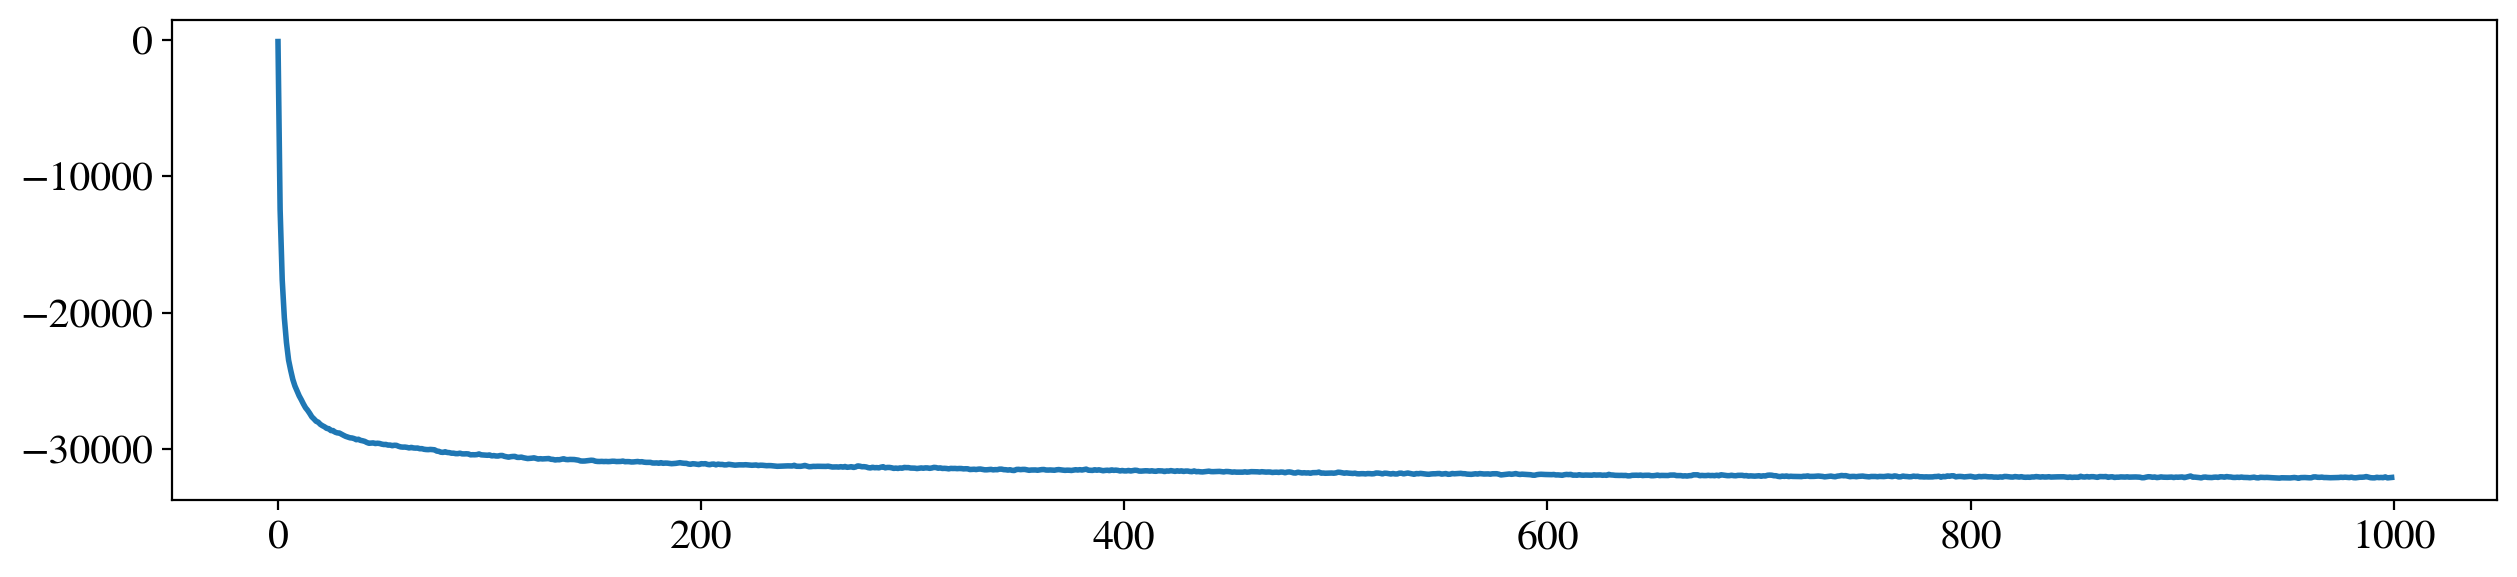

In [3]:
N = 128
S = 2 * np.random.randint(2, size=(N, N))-1 # Quick way to generate a random initial spin configuration
He_list, m_list = compute_quantities(S, 1, 1000, show_time= True)

step_list = np.arange(0, 1000)

fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(step_list, He_list)
plt.title(r"Energy as a function of Monte Carlo sweeps with $N$ = {}".format(N) + " and $T$ = {}".format(T) + " K")
plt.xlabel(r"$t$")
plt.ylabel(r"$E$")
plt.show()

plt.subplot(2, 1, 2)
plt.plot(step_list, m_list)
plt.title(r"Magnetization as a function of Monte Carlo sweeps with $N$ = {}".format(N) + " and $T$ = {}".format(T) + " K")
plt.xlabel(r"$t$")
plt.ylabel(r"$m$")
plt.show()